### Fake News Classification using machine learning
**Project Workflow**
0. Installing required libraies from requirements.txt for project 
1. Problem Statement
2. Data Collection
3. Importing required libraries and installations
4. Importing data as csv file
5. Exploratory Data Analysis
6. Data Preparation and Preprocessing
   - Tokenization
   - Lower case conversion
   - Stopwords
   - Lemmatization/Stemming
7. Vectorization with TFIDF
8. Data splittin into train and test
9. Model Building and Evaluation
  - 9.1 Cross validation
  - 9.2 Training data with best model from cross validation
  - 9.3. Evaluating the performance of trained model on test data
  - 9.4 Saving and loading model
10. Prediction pipeline


#### 0. Installing required libraies from requirements.txt for project 

In [7]:
!pip freeze > requirements.txt

#### 1. Problem Statement
The prevalence of fake news on online media platforms is increasingly recognized as a critical concern for society, as it has the potential to manipulate public opinion, incite social unrest, and erode trust in credible news sources. To mitigate the negative impact of fake news, the development of an effective classification system capable of accurately identifying and filtering false news articles from genuine sources is essential. However, building such a system presents numerous challenges, including the multifaceted and intricate nature of news content, the rapid dissemination of fake news through social media channels, and the possibility of biased or incomplete datasets. As such, it is imperative to develop an accurate and reliable fake news classification system leveraging advanced natural language processing (NLP) techniques. By achieving this, we can safeguard the integrity of news and promote public trust in media outlets.


#### 2. Data collection
The datasets is available on kaggle in the provided link 
https://www.kaggle.com/c/fake-news/data?select=train.csv


#### 3. Importing required libraries and installations

In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict
import re
import os
import nltk
import joblib
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score,classification_report,confusion_matrix
import xgboost
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
import catboost

#### 4. Importing data as csv file

In [2]:
#connect to goole drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#unzip data file 
!unzip -q "/content/drive/MyDrive/Upwork/Fake_news/Data/fake_news_train.csv.zip"

In [3]:
#Define path to data
data_path = "/content/train.csv"
#read data as dataframe
df = pd.read_csv(data_path)
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [11]:
# set the random state
random_state = 42
np.random.seed(random_state)

#### 5. Exploratory Data Analysis

In [ ]:
#check data shape
df.shape

(20800, 5)

In [ ]:
#check data types of features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [7]:
#drop id column
df = df.drop("id",axis= 1)
print(f"Columns are {df.columns}")

Columns are Index(['title', 'author', 'text', 'label'], dtype='object')


In [ ]:
#check missing values
df.isnull().sum()

title      558
author    1957
text        39
label        0
dtype: int64

In [ ]:
#Check number of classes in label
df["label"].value_counts()

1    10413
0    10387
Name: label, dtype: int64

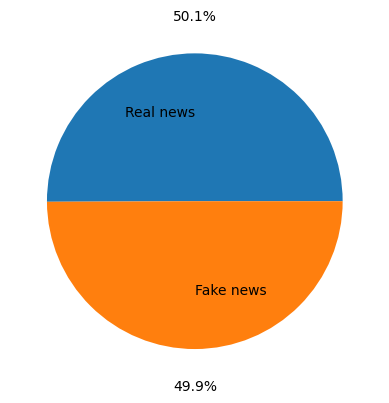

In [ ]:
#Draw distibution of classes in label to check for imbalance
sizes = df["label"].value_counts().values
labels = ["Real news","Fake news"]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%',
       pctdistance=1.25, labeldistance=.6)
plt.show()


Comment : Data is balanced

In [ ]:
#Check different titles
df["title"][5]

'Jackie Mason: Hollywood Would Love Trump if He Bombed North Korea over Lack of Trans Bathrooms (Exclusive Video) - Breitbart'

In [ ]:
#chek different text description of news
df["text"][1]

'Ever get the feeling your life circles the roundabout rather than heads in a straight line toward the intended destination? [Hillary Clinton remains the big woman on campus in leafy, liberal Wellesley, Massachusetts. Everywhere else votes her most likely to don her inauguration dress for the remainder of her days the way Miss Havisham forever wore that wedding dress.  Speaking of Great Expectations, Hillary Rodham overflowed with them 48 years ago when she first addressed a Wellesley graduating class. The president of the college informed those gathered in 1969 that the students needed “no debate so far as I could ascertain as to who their spokesman was to be” (kind of the like the Democratic primaries in 2016 minus the   terms unknown then even at a Seven Sisters school). “I am very glad that Miss Adams made it clear that what I am speaking for today is all of us —  the 400 of us,” Miss Rodham told her classmates. After appointing herself Edger Bergen to the Charlie McCarthys and Mor

Comment : only the title of the news with be used for training our model to decrease preprocessing time and reduce model complexity since every text description of news seems too large

#### 6. Data Preparation and preprocessing

In [4]:
#Dropping missing values
df = df.dropna().reset_index(drop=True)
df.shape

(18285, 5)

In [ ]:
df.head()

,title,author,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [5]:
#Downloading wordnet for nltk to avoid error
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
#initialise lemmatization object
lm = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))
def preprocess_text(df,feature):
        #initialise corpus to store texts p
        corpus = []
        for i in range(len(df)):
            review = re.sub("a-zA-Z0-9"," ",df[feature][i])
            review = review.lower() #convert to lower case
            review = review.split() #Tokenize text
            review = [lm.lemmatize(x) for x in review if x not in list(stop_words)] #lemmatize and removing stopwords
            review  = " ".join(review) #join as text
            corpus.append(review)
            
        return corpus
#preprocess text and get desired document 
corpus =   preprocess_text(df = df,feature = "title") 

In [10]:
#indexing on corpus
corpus[0]

'house dem aide: didn’t even see comey’s letter jason chaffetz tweeted'

#### 7. Vectorization with TFIDF

In [49]:
#Convert texts to array using tfidf vectorizer
def vectorize(corpus):
  tf = TfidfVectorizer(random_state=random_state)
  x = tf.fit_transform(corpus).toarray()
  return x,tf
x,tf = vectorize(corpus)

In [50]:
#save preprocessor
# Save the TF-IDF preprocessor using joblib
os.chdir("/content/drive/MyDrive/Upwork/Fake_news/Artifacts")
joblib.dump(tf, 'tfidf_preprocessor.pkl')


['tfidf_preprocessor.pkl']

#### 8. Data splitting into train and test

In [12]:
#split data into training and test using 20 % as test data
y = df["label"]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=random_state,stratify = y)

In [13]:
print(f"Training data size {len(x_train)}")
print(f"Test data size {len(x_test)}")

Training data size 14628
Test data size 3657


#### 9. Model building

9.1 Cross validation

In [18]:
#Define a dictionary of models to be used for cross validation
models = {"logistic_regression":LogisticRegression(),
          "Naive_Bayes":GaussianNB(),
          "catboost":catboost.CatBoostClassifier(iterations = 100,random_state=random_state,silent=True)}

In [15]:

model_scores  = [] # define list to store scores of models
model_names = models.keys() #define for names of models

def cross_validate(model,x_train:np.ndarray,y_train:np.ndarray,scoring:str):
    #Cross validate through every model
    cv_results = cross_val_score(model,x_train, y_train, cv=5, scoring=scoring)
    mean_accuracy = cv_results.mean()
    acc = model_scores.append(mean_accuracy)
    return acc
#cross validate with logistci regression
#cross_validate(model=models["logistic_regression"],x_train=x_train,y_train= y_train,scoring="accuracy")

In [17]:
#cross validate with Naive nayes
cross_validate(model=models["Naive_Bayes"],x_train=x_train,y_train=y_train,scoring="accuracy")

In [18]:
#create dataframe for results
result_df = pd.DataFrame()
result_df["model"] = ["logistic_regression","Naive Bayes"]
result_df["Accuracy"] = model_scores
result_df_sorted = result_df.sort_values("Accuracy",ascending=False)

#save dataframe to result folder
path_to_result = "/content/drive/MyDrive/Upwork/Fake_news/Results"
os.chdir(path_to_result)
result_df_sorted.to_csv("crossval_scores.csv",index=False)
result_df_sorted.head()

,model,Accuracy
0,logistic_regression,0.916735
1,Naive Bayes,0.646158


In [19]:
#cross validate with xgboost
cb_score = cross_validate(model=models["catboost"],x_train=x_train,y_train=y_train,scoring="accuracy") 

In [24]:
cb_score = model_scores[0]

In [25]:
cb_score

0.9191961722488038

In [26]:
#Read saved dataframed for other trained model
result_df_sorted = pd.read_csv("/content/drive/MyDrive/Upwork/Fake_news/Results/crossval_scores.csv")
# create a new row
new_row = {'model': 'catboost', 'Accuracy':cb_score}
# append the new row to the DataFrame
result_df_sorted = result_df_sorted.append(new_row, ignore_index=True)

<ipython-input-26-e45b92f89ffd>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df_sorted = result_df_sorted.append(new_row, ignore_index=True)


In [27]:
#create dataframe for results
result_df_sorted.to_csv("cross_val.csv",index=False)
result_df_sorted.head()

,model,Accuracy
0,logistic_regression,0.916735
1,Naive Bayes,0.646158
2,catboost,0.919196


Comment : Catboost happens to be the best model so far,we will train our data with this model

9.2 Training data with best model from cross validation

In [28]:
model = catboost.CatBoostClassifier(iterations = 100,random_state=random_state,silent=True)
#train model
model.fit(x_train,y_train)

9.3 Evaluating the performance of trained model on test data

In [29]:
#predict on test data
y_pred= model.predict(x_test)

In [31]:
#get accuracy,f1_score and auc_roc_score
y_true  = y_test
print(f"Accuracy:{accuracy_score(y_true, y_pred)}")
print(f"f1_score:{f1_score(y_true, y_pred)}")
print(f"roc_auc_score:{roc_auc_score(y_true, y_pred)}")

Accuracy:0.9278096800656276
f1_score:0.9221238938053098
roc_auc_score:0.9346622535108339


In [33]:
#print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.88      0.93      2072
           1       0.87      0.99      0.92      1585

    accuracy                           0.93      3657
   macro avg       0.93      0.93      0.93      3657
weighted avg       0.94      0.93      0.93      3657



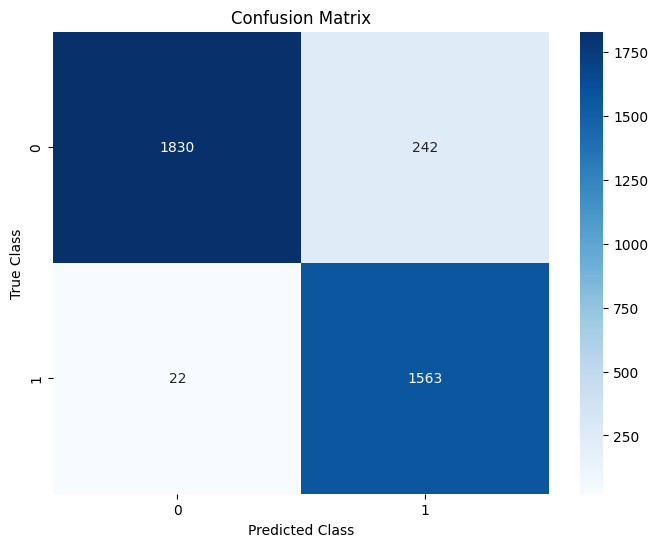

In [36]:
#plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Save the classification report to a file
report = classification_report(y_test, y_pred)
with open("classification_report.txt", "w") as f:
    f.write(report)
os.chdir("/content/drive/MyDrive/Upwork/Fake_news/Results")
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d",)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.savefig("confusion_matrix.png")

#### 9.4 Saving  and loading model


In [38]:
#save model
path_to_save = "/content/drive/MyDrive/Upwork/Fake_news/Models"
os.chdir(path_to_save)
model.save_model("cb_fakes_news_model.cbm")
#load saved model
loaded_model = catboost.CatBoostClassifier()
loaded_model.load_model('cb_fakes_news_model.cbm')

#### 10. Prediction pipeline

In [80]:
class Preprocessing:
  def __init__(self,data):
     self.data = data

  def preprocess_text(self):
        lm = WordNetLemmatizer()
        #initialise corpus to store texts p
        pred_data = [self.data]
        preprocessed_data = []

        for data in pred_data:
            review = re.sub("a-zA-Z0-9"," ",data)
            review = review.lower() #convert to lower case
            review = review.split() #Tokenize text
            review = [lm.lemmatize(x) for x in review if x not in list(stop_words)] #lemmatize and removing stopwords
            review  = " ".join(review) #join as text
            preprocessed_data.append(review)
            
        return preprocessed_data

class Prediction:
  def __init__(self,pred_data,model):
      self.pred_data = pred_data
      self.model = model



  def predict(self):
    preprocess_data = Preprocessing(self.pred_data).preprocess_text()

    # Load the saved TF-IDF preprocessor using joblib
    path = "/content/drive/MyDrive/Upwork/Fake_news/Artifacts/tfidf_preprocessor.pkl"
    loaded_tfidf = joblib.load(path)
    data = loaded_tfidf.transform(preprocess_data)
    predicted = self.model.predict(data)

    if predicted[0] == 0:
      return "The news is fake"
    else:
      return "The news is real"


    

In [69]:
df["title"][8]

'Obama’s Organizing for Action Partners with Soros-Linked ‘Indivisible’ to Disrupt Trump’s Agenda'

In [99]:
#make prediction on user data
single_data = df["title"][10]
pred_ = Prediction(single_data,loaded_model).predict()
pred_

['russian researcher discover secret nazi military base ‘treasure hunter’ arctic [photos]']